In [1]:
import limbo
from limbo.processing import CALGAIN
from limbo.database import HEADER, DATABASE_DIR
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import shutil
import time
from scipy.ndimage import maximum_filter1d, zoom
import glob

%matplotlib inline
# %matplotlib notebook

# %load_ext memory_profiler

In [2]:
filename = os.environ['LIMBO_PROCFILE']
INJECT_FRB = 0
NSIG = 5.5
MAX_DM = 100
MASK_DM = 30
EXCLUDE_S = float(os.environ.get('LIMBO_EXCLUDE_S', '0.05'))
REMOVE_DIR = os.environ.get('LIMBO_REMOVE_DIR', None)
SAVE_DIR = os.environ.get('LIMBO_SAVE_DIR', None)
VOLT_DIR = os.environ.get('LIMBO_VOLT_DIR', None)
VOLT_SAVE_DIR = os.environ.get('LIMBO_VOLT_SAVE_DIR', None)
CH0, CH1 = 398, 398+1024
UPDATE_DATABASE = eval(os.environ.get('LIMBO_UPDATE_DATABASE', True))

print('Processing:', filename)
print('INJECT_FRB:', INJECT_FRB)
print('NSIG:', NSIG)
print('MAX_DM:', MAX_DM)
print('MASK_DM:', MASK_DM)
print('EXCLUDE_S:', EXCLUDE_S)
print('REMOVE_DIR:', REMOVE_DIR)
print('SAVE_DIR:', SAVE_DIR)
print('VOLT_DIR:', VOLT_DIR)
print('VOLT_SAVE_DIR:', VOLT_SAVE_DIR)
print('UPDATE_DATABASE:', UPDATE_DATABASE)

Processing: /home/obs/data/save/Spectra_20230707193215.dat
INJECT_FRB: 0
NSIG: 5.5
MAX_DM: 100
MASK_DM: 30
EXCLUDE_S: 0.05
REMOVE_DIR: None
SAVE_DIR: None
VOLT_DIR: None
VOLT_SAVE_DIR: None
UPDATE_DATABASE: False


In [3]:
hdr, data = limbo.io.read_file(filename)
print('Observed:', time.ctime(hdr['Time']))
for k, v in hdr.items():
    print(f'    {k:15s}: {v}')
ker = int(np.around(EXCLUDE_S / hdr['inttime']))
print(f'ker={ker}')

Observed: Fri Jul  7 19:32:11 2023
    SWVer          : 0.0.4
    fpg            : limbo_500_m_2023-05-09_1203.fpg
    Time           : 1688758331.683537
    AccLen         : 128
    AdcCoarseGain  : 4
    FFTShift       : 2047
    DataSel        : 1
    Scaling        : 0
    Pol0EqCoeff    : 59904
    Pol1EqCoeff    : 59904
    SpecCoeff      : 4
    AdcDelay0      : 5
    AdcDelay1      : 5
    AdcDelay2      : 5
    AdcDelay3      : 5
    AdcDelay4      : 5
    AdcDelay5      : 5
    AdcDelay6      : 5
    AdcDelay7      : 5
    RF_Lo_Hz       : 1350000000
    Source         : crab
    Target_RA_Deg  : 05h34m31.95s
    Target_DEC_Deg : +22d00m52.2s
    Pointing_AZ    : 217.57
    Pointing_EL    : 70.83
    Pointing_Updated: 1688758334.768144
    filename       : /home/obs/data/save/Spectra_20230707193215.dat
    sample_clock   : 500000000.0
    freqs          : [1.35000000e+09 1.35012207e+09 1.35024414e+09 ... 1.59963379e+09
 1.59975586e+09 1.59987793e+09]
    Time_created   : 1688

In [4]:
class Summary:
    
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.dms ={
            (0, 20): [],
            (20, 40): [],
            (40, 60): [],
            (60, 80): [],
            (80, 100): []
        }
        self.avg_spec = []
        self.gain_vs_t = []
    
    def add_summary(self, summary):
        dm_vs_t = summary['dmt']
        dms = summary['dms']
        for (lo, hi) in self.dms.keys():
            try:
                self.dms[lo, hi].append(np.max(dm_vs_t[:,np.logical_and(hi > dms, dms >= lo)], axis=1))
            except(ValueError):
                pass
    
    def get_summary(self):
        rv = {}
        for k, v in self.dms.items():
            try:
                rv[k] = np.concatenate(v)
            except(ValueError):
                pass
        return rv
    
    def get_events(self, ker, nsig, summary=None, in_keys=[(40,60)], out_keys=[(0,20), (20,40)],
                   verbose=True):
        if summary is None:
            summary = self.get_summary()
            
        events = {}
        for k, v in summary.items():
            if type(k) == str:
                continue
            avg = np.median(v)
            sig = np.median(np.abs(v - avg))
            zscore = (v - avg) / sig
            if verbose:
                print(f'DM={k}: avg={avg:7.2f} +/- {sig:7.2f}')
            events[k] = zscore
        events['out'] = np.array([events[k] for k in out_keys]).max(axis=0)
        events['in'] = np.array([events[k] for k in in_keys]).max(axis=0)
        events['thresh'] = np.ones_like(events['out']) * nsig
        events['interesting'] = (events['in'] > events['thresh'])
        return events

In [5]:
# Process the data
dts = hdr['times'] - hdr['times'][0]

if INJECT_FRB:
    sim_frb = limbo.sim.make_frb(hdr['times'], hdr['freqs'], DM=57,
                                 pulse_width=0.12e-3, pulse_amp=15, t0=hdr['times'][3000])
    sim_frb *= (limbo.processing.FMDL / limbo.processing.FMDL.max())
    data = data + sim_frb
    
dmt = limbo.processing.process_data(hdr, data, maxdm=MAX_DM, 
                                    inpaint=True, ch0=CH0, ch1=CH1)

summary = Summary()
summary.add_summary(dmt)
report = summary.get_summary()
events = summary.get_events(ker, NSIG, summary=report)
interesting = np.any(events['interesting'])

/home/obs/Software/miniconda3/envs/py38/lib/python3.8/site-packages/limbo/processing.py:103: RuntimeWarning: invalid value encountered in divide
  fzsq = np.sum(full_mask * zsq, axis=0) / np.sum(full_mask, axis=0)


DM=(0, 20): avg= 691.19 +/-  158.10
DM=(20, 40): avg= 775.11 +/-  188.96
DM=(40, 60): avg= 791.85 +/-  186.19
DM=(60, 80): avg= 777.14 +/-  187.74
DM=(80, 100): avg= 783.90 +/-  201.33


In [6]:
### STAGE 1: Look for all events above threshold.
print(f"DMs: {dmt['dms'][0]} -- {dmt['dms'][-1]}")
for k, v in events.items():
    if k == 'interesting':
        print(f'{k}: {(v > 0).sum()} event(s)')
    elif type(k) is tuple:
        event_ts = (v > events['thresh'])
        nevents = event_ts.sum()
        print(f'{k}: {nevents} event(s)', end='')
        if nevents > 0:
            ki = np.searchsorted(dmt['dms'], k[0])
            kj = np.searchsorted(dmt['dms'], k[1])
            inds = np.argmax(dmt['dmt'][event_ts, ki:kj], axis=1)
            print(f', nsig_max={v[v > events["thresh"]].max():3.1f}, dms={dmt["dms"][ki:kj][inds]}')
        else:
            print()
print('\nAnything Interesting:', interesting)

DMs: 0.0 -- 99.90234375
(0, 20): 6 event(s), nsig_max=6.7, dms=[19.53125    15.72265625 19.921875   19.921875   16.015625   17.3828125 ]
(20, 40): 5 event(s), nsig_max=6.6, dms=[24.21875   39.84375   38.4765625 39.84375   35.9375   ]
(40, 60): 12 event(s), nsig_max=16.5, dms=[59.9609375  57.2265625  52.9296875  49.0234375  44.921875   40.625
 46.09375    42.1875     56.25       40.0390625  47.4609375  56.15234375]
(60, 80): 9 event(s), nsig_max=14.5, dms=[77.34375    69.921875   65.625      61.328125   60.05859375 60.9375
 78.7109375  74.609375   74.0234375 ]
(80, 100): 5 event(s), nsig_max=6.7, dms=[99.0234375 94.921875  90.625     91.9921875 99.8046875]
interesting: 12 event(s)

Anything Interesting: True


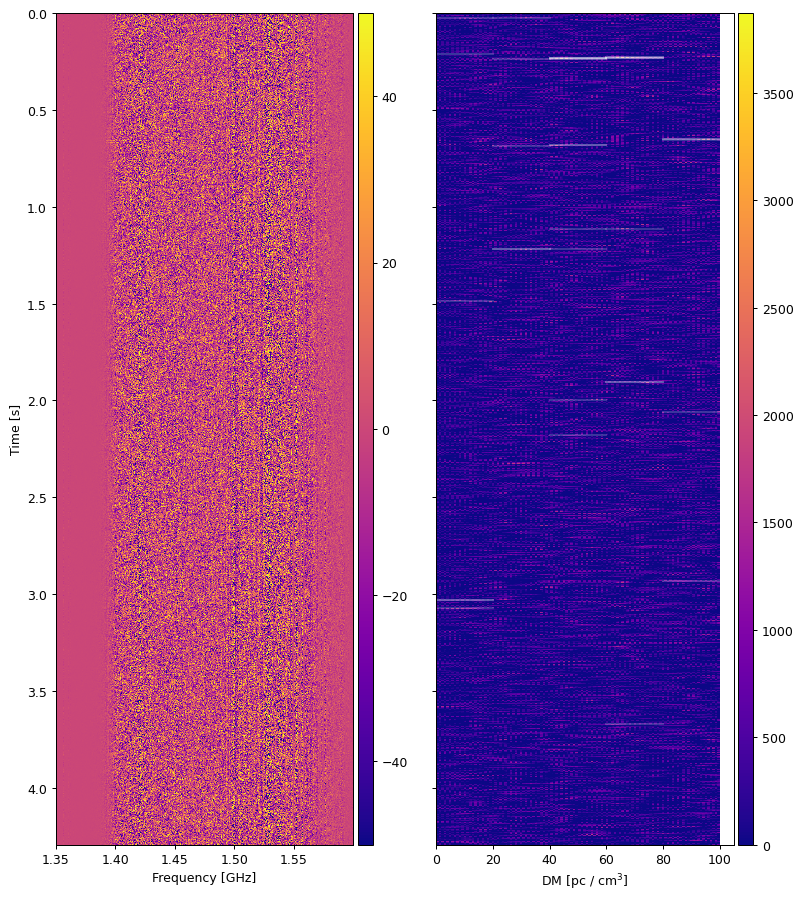

In [7]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)

scale = 50
im0 = axes[0].imshow(np.where(dmt['diff'] == 0, np.nan, dmt['diff']),
               extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
               cmap='plasma', vmax=scale, vmin=-scale, interpolation='nearest', aspect='auto')
im1 = axes[1].imshow(dmt['dmt'], cmap='plasma', vmin=0,
               extent=(dmt['dms'][0], dmt['dms'][-1], dts[-1], dts[0]),
               interpolation='nearest', aspect='auto')
for k, v in events.items():
    if type(k) is str:
        continue
    for t in dts[v > events['thresh']]:
        axes[1].plot(k, (t, t), 'w', alpha=0.2)
axes[0].set_xlabel('Frequency [GHz]')
axes[1].set_xlabel('DM [pc / cm$^3$]')
axes[0].set_ylabel('Time [s]')
cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im0, cax=cax)
cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
_ = plt.colorbar(im1, cax=cax)

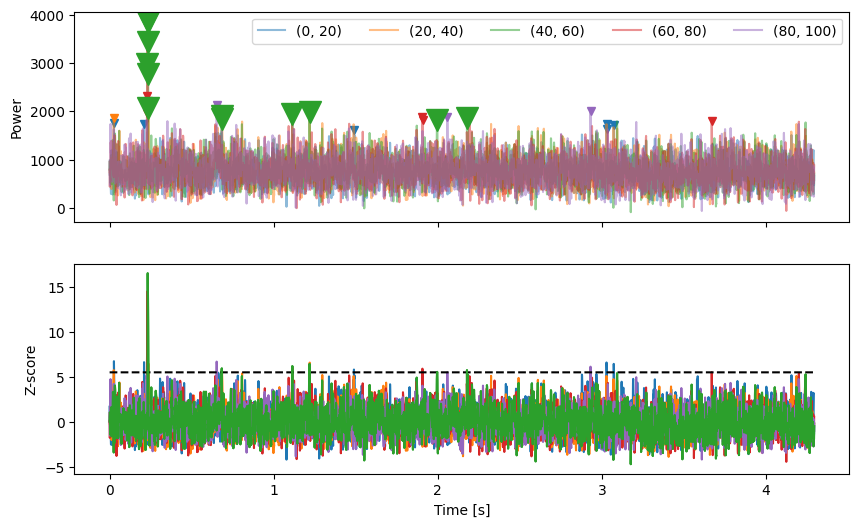

In [8]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6))
colors = {}
for k, v in events.items():
    if type(k) == str:
        continue
    line, = axes[0].plot(dts, report[k], label=k, alpha=0.5)
    colors[k] = line.get_color()
    axes[0].plot(dts[v > events['thresh']], report[k][v > events['thresh']], 'v', color=line.get_color())
    axes[1].plot(dts, v, color=colors[k])
    
k = (40, 60)
v = events[k]
axes[0].plot(dts[events['interesting'] & (v > events['thresh'])], 
             report[k][events['interesting'] & (v > events['thresh'])], 
             'v', color=colors[k], markersize=16)
axes[1].plot(dts, events['thresh'], 'k', linestyle='dashed')
axes[1].plot(dts, events['in'], color=colors[k])
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel('Power')
axes[1].set_ylabel('Z-score')
_ = axes[0].legend(ncol=5)

In [11]:
### STAGE 2: For all 40-60 DM events de-disperse them to DM of Crab. 
## Keep only those that can be de-dispersed to that DM.
if interesting:
    cal_data = dmt['diff'] * CALGAIN
    k = (40, 60)
    DM = 56.7
    resamp_factor = 4 # factor to over-sample by
    delays = limbo.sim.DM_delay(DM, hdr['freqs']).astype('float32')
    delays -= delays[-1]  # center lowest delay at t0
    profile = limbo.utils.dedisperse(cal_data, DM, hdr['freqs'], hdr['inttime'], resamp_factor)
    thresh_interp = zoom(events['thresh'], zoom=resamp_factor, 
                         mode='nearest', order=0) # over-sample events['thresh']

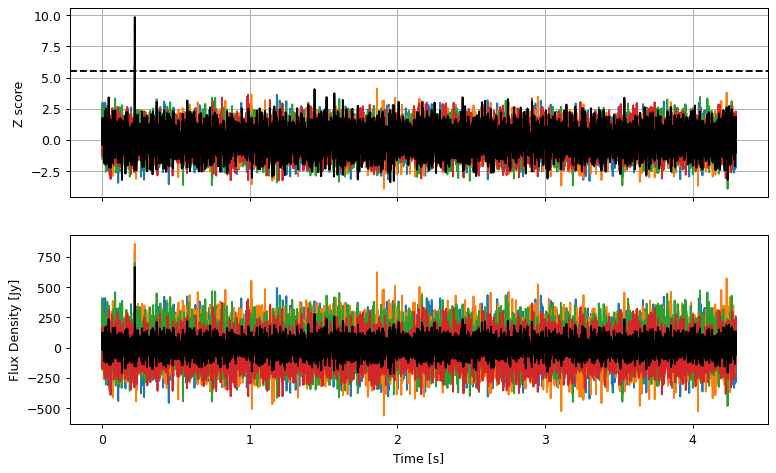

In [12]:
if interesting:
    _dts = np.linspace(hdr['times'][0], hdr['times'][-1], profile.shape[0], endpoint=False) # Unix time
    zeroed_dts = _dts - hdr['Time']
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(10, 6), dpi=90)
    freq_binned_profile = np.mean(profile[:, CH0:CH1].reshape(profile.shape[0], -1, 256), axis=-1)
    avg_profile = np.mean(profile[:, CH0:CH1], axis=-1)
    zscore = (avg_profile - np.mean(avg_profile)) / np.std(avg_profile)
    axes[0].plot(zeroed_dts, (freq_binned_profile - np.mean(freq_binned_profile, axis=0, keepdims=True)) / np.std(freq_binned_profile, axis=0, keepdims=True))
    axes[0].plot(zeroed_dts, (avg_profile - np.mean(avg_profile)) / np.std(avg_profile), 'k')
    axes[0].axhline(NSIG, color='k', ls='dashed')
    axes[1].plot(zeroed_dts, freq_binned_profile)
    axes[1].plot(zeroed_dts, avg_profile, 'k')
    axes[1].set_xlabel('Time [s]')
    axes[0].set_ylabel('Z score')
    axes[0].grid()
    axes[1].set_ylabel('Flux Density [Jy]')

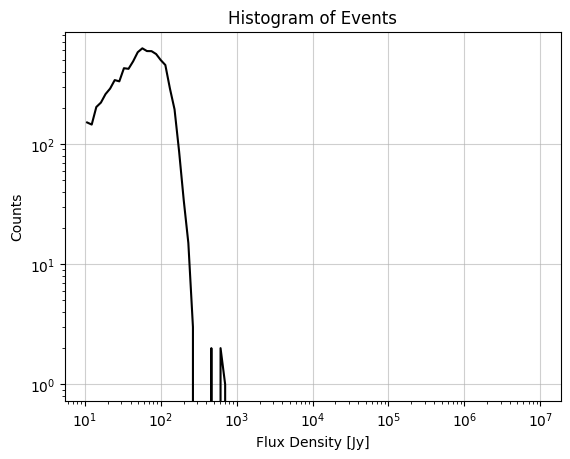

In [13]:
if interesting:
    plt.figure()
    _bins = np.linspace(1, 7, 100)
    hist, bins_edges = np.histogram(np.log10(avg_profile[avg_profile>0]), bins=_bins)
    bins = 0.5*(bins_edges[1:] + bins_edges[:-1])
    plt.loglog(10**bins, hist, color='k')
    plt.xlabel('Flux Density [Jy]')
    plt.ylabel('Counts')
    plt.title('Histogram of Events')
    plt.grid(alpha=0.6)
    plt.show()
else:
    hist, bins = np.nan, np.nan
    zmax = np.nan
    tind_events = np.array([])
    

In [14]:
### STAGE 3: Of the surviving events, determine if their de-dispersed z-scores are above a threshold.
save_file = False
if interesting:
    tind_events = np.where((zscore > thresh_interp))[0]
    if tind_events.size > 0:
        zmax = np.max(zscore[tind_events])
        print(f'De-dispersed Z-score: {zmax:4.1f}')
        save_file = True
        
if not save_file:
    zmax = np.max(zscore)
        
print('Save file:', save_file)

De-dispersed Z-score:  9.9
Save file: True


In [15]:
if save_file:
    print(f'Number of events: {tind_events.size}')
    print(f'Time of events: {zeroed_dts[tind_events]}')
    print(f'Max measured flux: {np.max(avg_profile)} Jy')

Number of events: 5
Time of events: [0.22171974 0.22198176 0.22224379 0.22250581 0.22276807]
Max measured flux: 665.36181640625 Jy


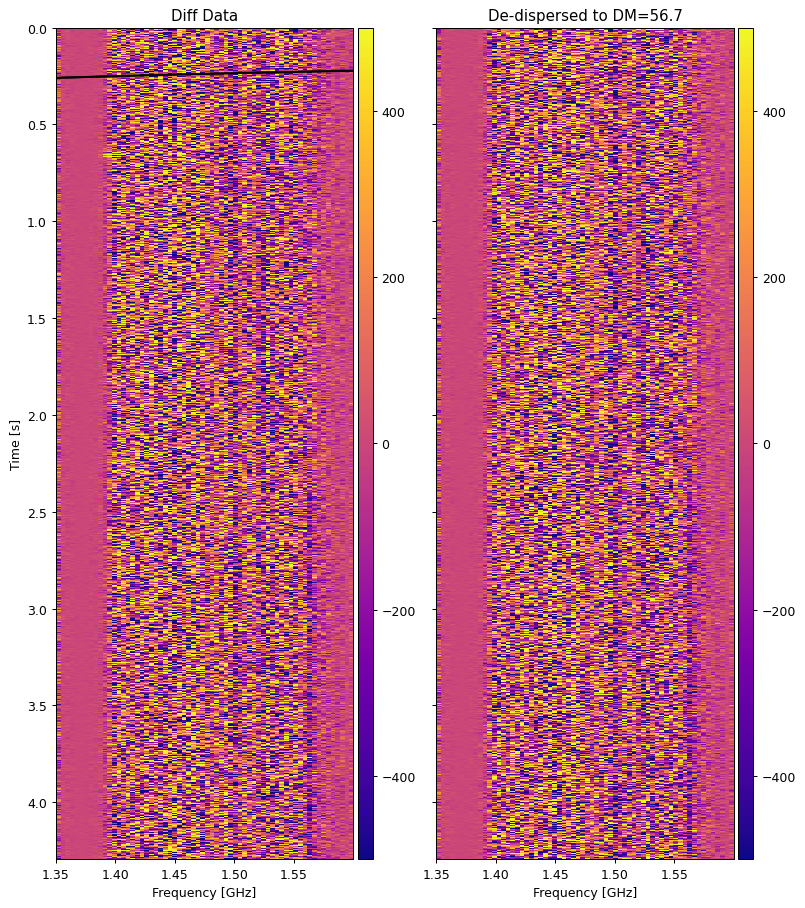

In [16]:
if save_file:
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 12), dpi=90)
#     scale = 5000
    min_scale, max_scale = -500, 500
    cd = cal_data.copy()
    cd.shape = (cd.shape[0], -1, 32)
    pd = profile[::resamp_factor].copy() # return to raw sampling
    pd.shape = (pd.shape[0], -1, 32)
    cd = np.mean(cd, axis=-1)
    pd = np.mean(pd, axis=-1)
    im0 = axes[0].imshow(cd, extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
                   cmap='plasma', vmax=max_scale, vmin=min_scale, interpolation='nearest', aspect='auto')
    im1 = axes[1].imshow(pd, extent=(hdr['freqs'][0] / 1e9, hdr['freqs'][-1] / 1e9, dts[-1], dts[0]),
                   cmap='plasma', vmax=max_scale, vmin=min_scale, interpolation='nearest', aspect='auto')
    for event in tind_events:
        t = zeroed_dts[event]
        axes[0].plot(hdr['freqs'] / 1e9, t + delays, 'k', alpha=0.5)
    axes[0].set_xlabel('Frequency [GHz]')
    axes[1].set_xlabel('Frequency [GHz]')
    axes[0].set_title(f'Diff Data')
    axes[1].set_title(f'De-dispersed to DM={DM:3.1f}')
    axes[0].set_ylabel('Time [s]')
    cax = make_axes_locatable(axes[0]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im0, cax=cax)
    cax = make_axes_locatable(axes[1]).append_axes('right', size='5%', pad=0.05)
    _ = plt.colorbar(im1, cax=cax)

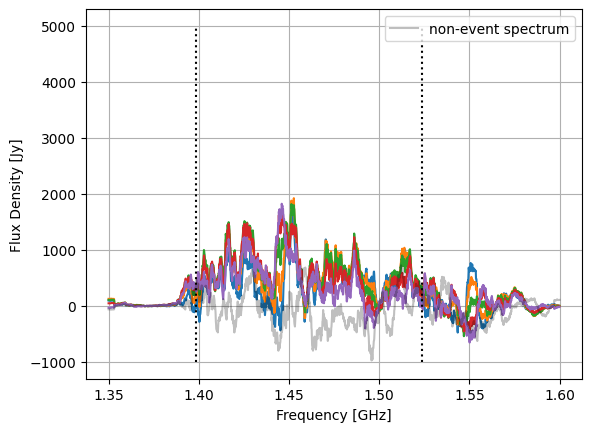

In [17]:
if save_file:
    KER = 50
    plt.figure()
    for i in tind_events:
        plt.plot(hdr['freqs'] / 1e9, np.convolve(profile[i], np.ones(KER)/KER, mode='same'))
    plt.plot(hdr['freqs'] / 1e9, np.convolve(profile[100], np.ones(KER)/KER, mode='same'), alpha=0.25, color='k', label='non-event spectrum')
    plt.vlines([hdr['freqs'][CH0] / 1e9, hdr['freqs'][CH1] / 1e9], -1e3, 5e3, color='k', linestyles='dotted')
    plt.grid()
    plt.legend()
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Flux Density [Jy]')
    plt.show()

In [18]:
if save_file:
    if SAVE_DIR != None:
        outfile = os.path.join(SAVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
        os.rename(filename, outfile)
    if VOLT_SAVE_DIR != None and VOLT_DIR != None:
        volt_files = sorted(glob.glob(os.path.join(VOLT_DIR, '*.dat')))
        start_times = np.array([limbo.io.read_start_time(f) for f in volt_files]) - hdr['Time']
        save_vfiles = [f for f, t in zip(volt_files, start_times) if t > -1 and t < 5]
        for vfile in save_vfiles:
            outfile = os.path.join(VOLT_SAVE_DIR, os.path.basename(vfile))
            print(f'Moving {vfile} -> {outfile}')
#             os.rename(vfile, outfile)
            shutil.copy(vfile, outfile)
            os.remove(vfile)
else:
    if REMOVE_DIR != None:
        outfile = os.path.join(REMOVE_DIR, os.path.basename(filename))
        print(f'Moving {filename} -> {outfile}')
#         os.rename(filename, outfile)
        shutil.copy(filename, outfile)
        os.remove(filename)
        # Voltage data deletes automatically when ring buffer fills + overwrites

In [20]:
if UPDATE_DATABASE:
    thresh_vals, thresh_cnts = np.unique(events['thresh'], return_counts=True)
    tmask_vals, tmask_cnts = np.unique(dmt['tmask'], return_counts=True)
    db = [filename, 
          hdr['Time'],
          hdr['Target_RA_Deg'],
          hdr['Target_DEC_Deg'], 
          tind_events.size,
          zmax,
          hist,
          bins,
          thresh_vals,
          thresh_cnts,
          tmask_vals,
          tmask_cnts]

    database = dict(zip(HEADER, db))
    np.savez(os.path.join(DATABASE_DIR, os.path.basename(filename)), **database)

In [1]:
# %memit